A política aprendida com Q-learning linear está representada com setas nos estados não terminais, enquanto os estados terminais (+1, –1) e a parede são indicados com cores.

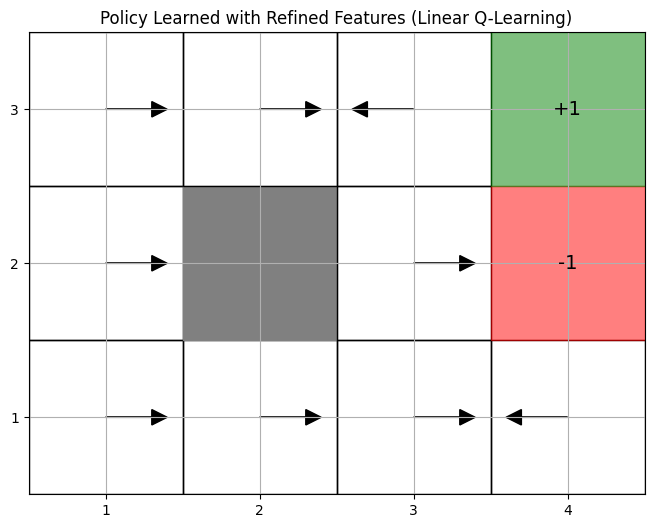

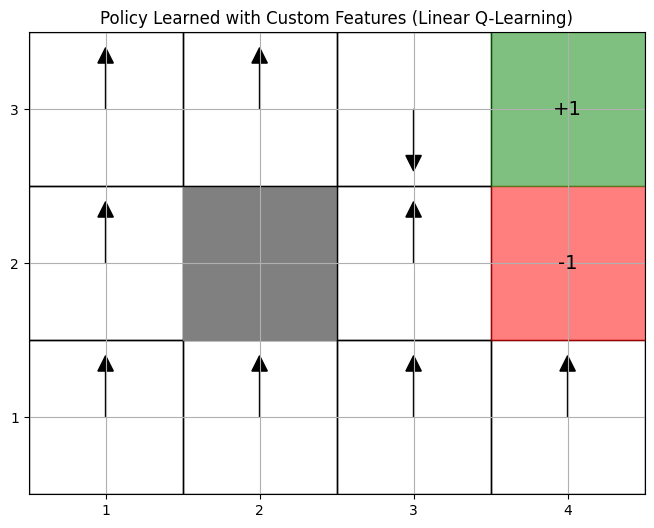

In [9]:
# Re-import necessary packages after kernel reset
import numpy as np
import random
import matplotlib.pyplot as plt

# Environment setup
cols, rows = 4, 3
start_state = (1, 1)
terminals = {(4, 3): +1, (4, 2): -1}
walls = {(2, 2)}
actions = ['up', 'down', 'left', 'right']
action_vectors = {
    'up': (0, 1), 'down': (0, -1), 'left': (-1, 0), 'right': (1, 0)
}
living_reward = -0.1

def get_possible_moves(action):
    if action == 'up':
        return [('up', 0.8), ('left', 0.1), ('right', 0.1)]
    elif action == 'down':
        return [('down', 0.8), ('left', 0.1), ('right', 0.1)]
    elif action == 'left':
        return [('left', 0.8), ('up', 0.1), ('down', 0.1)]
    elif action == 'right':
        return [('right', 0.8), ('up', 0.1), ('down', 0.1)]

def move(state, action):
    moves = get_possible_moves(action)
    chosen = random.choices(moves, weights=[p for _, p in moves])[0][0]
    dx, dy = action_vectors[chosen]
    nx, ny = state[0] + dx, state[1] + dy
    if (nx, ny) in walls or not (1 <= nx <= cols and 1 <= ny <= rows):
        return state
    return (nx, ny)

class LinearQAgentCustomFeatures:
    def __init__(self, actions, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_min=0.05, decay=0.0005):
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.decay = decay
        self.weights = {a: np.zeros(8) for a in actions}  # 8 refined features

    def featurize(self, state):
        x, y = state
        gx, gy = 4, 3
        inv_dist_to_goal = 1 / (1 + abs(x - gx) + abs(y - gy))
        aligned_x = 1 if x == gx else 0
        aligned_y = 1 if y == gy else 0
        is_42 = 1 if (x, y) == (4, 2) else 0
        adjacent_to_bad_terminal = 0
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            neighbor = (x + dx, y + dy)
            if terminals.get(neighbor, 0) < 0:
                adjacent_to_bad_terminal = 1
                break
        return np.array([1, x, y, inv_dist_to_goal, aligned_x, aligned_y, is_42, adjacent_to_bad_terminal])

    def predict(self, state, action):
        phi = self.featurize(state)
        return np.dot(self.weights[action], phi)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        values = {a: self.predict(state, a) for a in self.actions}
        return max(values, key=values.get)

    def update(self, state, action, reward, next_state, done):
        phi = self.featurize(state)
        q_sa = self.predict(state, action)
        target = reward if done else reward + self.gamma * max(self.predict(next_state, a) for a in self.actions)
        self.weights[action] += self.alpha * (target - q_sa) * phi
        self.epsilon = max(self.epsilon_min, self.epsilon * np.exp(-self.decay))

    def get_policy(self):
        policy = {}
        for x in range(1, cols + 1):
            for y in range(1, rows + 1):
                if (x, y) in walls or (x, y) in terminals:
                    continue
                values = {a: self.predict((x, y), a) for a in self.actions}
                policy[(x, y)] = max(values, key=values.get)
        return policy

# Treinamento
agent = LinearQAgentCustomFeatures(actions)
episodes = 5000
episode_rewards = []

for ep in range(episodes):
    state = start_state
    total_reward = 0
    while state not in terminals:
        action = agent.choose_action(state)
        next_state = move(state, action)
        reward = terminals.get(next_state, living_reward)
        agent.update(state, action, reward, next_state, next_state in terminals)
        state = next_state
        total_reward += reward
    episode_rewards.append(total_reward)

# Obter política aprendida
policy = agent.get_policy()

# Visualizar política aprendida
fig, ax = plt.subplots(figsize=(8, 6))
arrow_dir = {'up': (0, 0.3), 'down': (0, -0.3), 'left': (-0.3, 0), 'right': (0.3, 0)}

for x in range(1, cols + 1):
    for y in range(1, rows + 1):
        pos = (x, y)
        if pos in walls:
            ax.add_patch(plt.Rectangle((x - 1, y - 1), 1, 1, color='gray'))
        elif pos in terminals:
            color = 'green' if terminals[pos] > 0 else 'red'
            ax.add_patch(plt.Rectangle((x - 1, y - 1), 1, 1, color=color, alpha=0.5))
            ax.text(x - 0.5, y - 0.5, f"{terminals[pos]:+.0f}", ha='center', va='center', fontsize=14)
        else:
            ax.add_patch(plt.Rectangle((x - 1, y - 1), 1, 1, edgecolor='black', fill=None))
            a = policy.get(pos, None)
            if a:
                dx, dy = arrow_dir[a]
                ax.arrow(x - 0.5, y - 0.5, dx, dy, head_width=0.1, head_length=0.1, color='black')

ax.set_xticks(np.arange(cols) + 0.5)
ax.set_yticks(np.arange(rows) + 0.5)
ax.set_xticklabels([str(x) for x in range(1, cols + 1)])
ax.set_yticklabels([str(y) for y in range(1, rows + 1)])
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.grid(True)
ax.set_title("Policy Learned with Refined Features (Linear Q-Learning)")
plt.gca().set_aspect('equal')
plt.show()

# Train agent
agent = LinearQAgentCustomFeatures(actions)
episodes = 15000
episode_rewards = []

for ep in range(episodes):
    state = start_state
    total_reward = 0
    while state not in terminals:
        action = agent.choose_action(state)
        next_state = move(state, action)
        reward = terminals.get(next_state, living_reward)
        agent.update(state, action, reward, next_state, next_state in terminals)
        state = next_state
        total_reward += reward
    episode_rewards.append(total_reward)

# Retrieve learned policy
policy = agent.get_policy()

# Plot policy
fig, ax = plt.subplots(figsize=(8, 6))
arrow_dir = {'up': (0, 0.3), 'down': (0, -0.3), 'left': (-0.3, 0), 'right': (0.3, 0)}

for x in range(1, cols + 1):
    for y in range(1, rows + 1):
        pos = (x, y)
        if pos in walls:
            ax.add_patch(plt.Rectangle((x - 1, y - 1), 1, 1, color='gray'))
        elif pos in terminals:
            color = 'green' if terminals[pos] > 0 else 'red'
            ax.add_patch(plt.Rectangle((x - 1, y - 1), 1, 1, color=color, alpha=0.5))
            ax.text(x - 0.5, y - 0.5, f"{terminals[pos]:+.0f}", ha='center', va='center', fontsize=14)
        else:
            ax.add_patch(plt.Rectangle((x - 1, y - 1), 1, 1, edgecolor='black', fill=None))
            a = policy.get(pos, None)
            if a:
                dx, dy = arrow_dir[a]
                ax.arrow(x - 0.5, y - 0.5, dx, dy, head_width=0.1, head_length=0.1, color='black')

ax.set_xticks(np.arange(cols) + 0.5)
ax.set_yticks(np.arange(rows) + 0.5)
ax.set_xticklabels([str(x) for x in range(1, cols + 1)])
ax.set_yticklabels([str(y) for y in range(1, rows + 1)])
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.grid(True)
ax.set_title("Policy Learned with Custom Features (Linear Q-Learning)")
plt.gca().set_aspect('equal')
plt.show()


O gráfico a seguir mostra:

- Regret acumulado: quanto o agente deixou de ganhar em relação ao retorno ótimo ao longo do treinamento.

- Regret médio por episódio: tendência da eficiência do agente com o tempo.

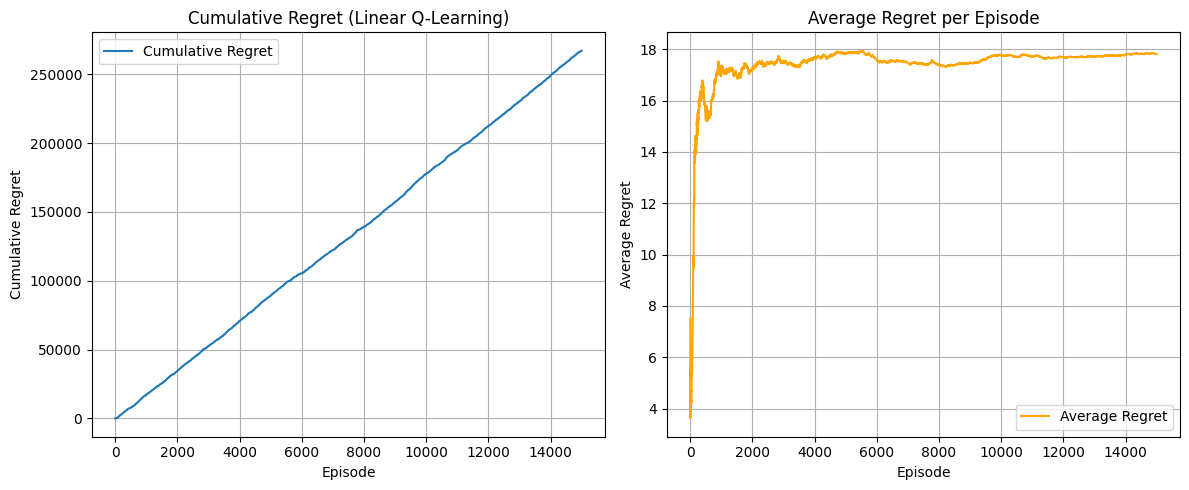

In [7]:
# Plot cumulative and average regret based on linear Q-learning results

# Supondo que o retorno ótimo seja 0.4 (atingir +1 em 6 passos com -0.1 por passo)
optimal_return = 0.4
episode_rewards = np.array(episode_rewards)
regret = np.cumsum(optimal_return - episode_rewards)
avg_regret = regret / np.arange(1, len(regret) + 1)

# Plot
plt.figure(figsize=(12, 5))

# Cumulative regret
plt.subplot(1, 2, 1)
plt.plot(regret, label="Cumulative Regret")
plt.xlabel("Episode")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret (Linear Q-Learning)")
plt.grid(True)
plt.legend()

# Average regret
plt.subplot(1, 2, 2)
plt.plot(avg_regret, color='orange', label="Average Regret")
plt.xlabel("Episode")
plt.ylabel("Average Regret")
plt.title("Average Regret per Episode")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
